# Webscraping at Zolo Real State Website.

In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from time import sleep
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

def root_mean_squared_error(y_true, p):
    mse = mean_squared_error(y_true, p)  # Calcula o erro médio quadrático
    rmse = np.sqrt(mse)  # Calcula a raiz do erro médio quadrático
    return rmse

### Getting the links to each building at Zolo website.

In [2]:
"""
 Second way --- using the "webdriver-manager"
 we will be able to always download the latest version of the "chromedriver" 
 using our Google Chrome version as a reference.
"""

#chrome_options = Options()
#chrome_options.add_argument("--headless")  # Executa o navegador em segundo plano

service=Service(ChromeDriverManager().install())
driver=webdriver.Chrome(service=service) #, options=chrome_options 

#allow us to navigate trough any page and to open a html archive in our pc.
#driver.get(r"https://www.zolo.ca/")
list_links=[]

page = 1
while page <= 100 :
    print(len(list_links))
    try:
        #define the link of the current page to be opened.'
        current_page = 'https://www.zolo.ca/toronto-real-estate/apartments-for-rent/page-'+str(page)
        #open a page based on the link formed.
        driver.get(current_page)
        #gets all the articles to a list.
        articles = driver.find_elements(By.TAG_NAME, 'article')
        #inside of each article it is looking for the "a hef" where we got the link to the detailed page.
        for article in articles:
            try:
                link = article.find_element(By.TAG_NAME, 'a').get_attribute('href')
                list_links.append(link)
                #print(link)
            except:
                continue
        #best order of elements -> ID > XPATH > CLASS_NAME
        #sleep(1)
        page += 1

        #creating the dataframe to input into sheets.
        df_links = pd.DataFrame(columns=['links_zolo'], data=list_links)

        #removing link duplicates.
        df_links.drop_duplicates(inplace=True)
    except:
        continue
        
driver.quit()
print('links: ', df_links.shape)

[WDM] - Downloading: 100%|█████████████████| 8.29M/8.29M [00:00<00:00, 9.75MB/s]


0
38
75
112
149
186
223
260
297
334
371
408
445
482
519
556
593
630
667
704
741
778
815
852
889
926
963
1000
1037
1074
1111
1148
1185
1222
1259
1296
1333
1370
1407
1444
1481
1518
1555
1592
1629
1666
1703
1740
1777
1814
1851
1888
1925
1962
1999
2036
2073
2110
2147
2184
2221
2258
2295
2332
2369
2406
2443
2480
2517
2554
2591
2628
2665
2702
2739
2776
2813
2850
2887
2924
2961
2998
3035
3072
3102
3103
3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
links:  (3002, 1)


In [4]:
#Put the data in a spreadsheet.
import gspread
import pandas as pd
import numpy as np

CODE = '1b4DllN1xFdujCzYnaMMWyC4tBg_gdmzT6G9GkqGT9Jo'

gc = gspread.service_account(filename='key.json')

sh = gc.open_by_key(CODE)

ws = sh.worksheet('Links')

ws.update([df_links.columns.values.tolist()] + df_links.values.tolist())

{'spreadsheetId': '1b4DllN1xFdujCzYnaMMWyC4tBg_gdmzT6G9GkqGT9Jo',
 'updatedRange': 'Links!A1:A2738',
 'updatedRows': 2738,
 'updatedColumns': 1,
 'updatedCells': 2738}

### Sistematizando a montagem do dataframe

In [ ]:
# Configura as opções do ChromeDriver para executar em modo headless
#chrome_options = Options()
#chrome_options.add_argument("--headless")  # Executa o navegador em segundo plano


service=Service(ChromeDriverManager().install())
driver=webdriver.Chrome(service=service) #, options=chrome_options
#esse bloco trata os dados que estao dentro do dicionario de dados que representa apenas imovel.
df = pd.DataFrame(columns=['Price', 'Address', 'Status', 'Type', 'Style', 'Age', 'Area', 'Community', 'Bedrooms', 'Bathrooms',
                           'Kitchens', 'Rooms', 'Den/Family Room', 'Patio Terrace', 'Air Conditioning', 'Fireplace', 'Handicap Equipped',
                           'Furnished', 'Laundry', 'Pets', 'Stories', 'Basement', 'Elevator', 'Energy Certificate', 'Heating',
                           'Green PIS', 'Exterior', 'Private Entrance', 'Central A/C Included', 'Garage', 'Cross Street',
                          'Water Included', 'Heating Included', 'Hydro Included', 'Municipality_District', 'Building Insurance Included',
                          'Bedroom Plus', 'Room Plus', 'Size', 'Age_cabecalho', 'Walk Score', 'Added'])

for i, link in enumerate(df_links['links_zolo']):
    print(link)
    driver.get(link)
    
    
    try:
        dados_detalhados_cabecalho = driver.find_element(By.XPATH,'/html/body/section[2]/div/div/section[5]/section')
    except NoSuchElementException:
        continue
    
    try:
        dados_detalhados_imovel = driver.find_element(By.XPATH, '/html/body/section[2]/div/div/section[5]/div/div/section[2]')
    except NoSuchElementException:
        try:
            dados_detalhados_imovel = driver.find_element(By.XPATH, '/html/body/section[2]/div/div/section[4]/div/div/section[1]')
        except NoSuchElementException:
            continue
    
    #have to click to the button in order to get more data.
    #driver.find_element(By.XPATH, '/html/body/section[2]/div/div/section[5]/div/button').click()
    try:
        price = driver.find_element(By.XPATH, '//*[@id="listing"]/div/div/section[1]/section[2]/div[1]').text
    except:                                   
        price='Ausente'
    try:
        address = driver.find_element(By.XPATH, '/html/body/section[2]/div/div/section[1]/section[1]/h1').text
    except:
        address = 'Ausente'
    try:
        driver.find_element(By.XPATH, '/html/body/section[2]/div/div/section[5]/div/button').click()
    except:
        driver.find_element(By.XPATH, '/html/body/section[2]/div/div/section[4]/div/button').click()
        
        
    #tratando os dados detalhados do cabecalho deestruturados.
    dados_detalhados_cabecalho = dados_detalhados_cabecalho.text
    lista_dados_cabecalho = dados_detalhados_cabecalho.split('\n')
    
    #Size
    if 'Size' in lista_dados_cabecalho:
        size_index = lista_dados_cabecalho.index('Size')
        Size = lista_dados_cabecalho[size_index+1]
    elif 'Size' not in lista_dados_cabecalho:
        Size = 'Ausente'
    
    #Age
    if 'Age' in lista_dados_cabecalho:
        age_index = lista_dados_cabecalho.index('Age')
        Age_cabecalho = lista_dados_cabecalho[age_index+1]
    elif 'Age' not in lista_dados_cabecalho:
        Age_cabecalho = 'Ausente'
    
    #Walk Score
    if 'Walk Score' in lista_dados_cabecalho:
        walk_score_index = lista_dados_cabecalho.index('Walk Score')
        Walk_Score = lista_dados_cabecalho[walk_score_index+1]
    elif 'Walk Score' not in lista_dados_cabecalho:
        Walk_Score = 'Ausente'
    
    #Walk Score
    if 'Added' in lista_dados_cabecalho:
        added_index = lista_dados_cabecalho.index('Added')
        Added = lista_dados_cabecalho[added_index+1]
    elif 'Added' not in lista_dados_cabecalho:
        Added = 'Ausente'
    
    
    #tratando os dados detalhados deestruturados.
    #-----------------------------------------------------------------------------------
    dados_detalhados_imovel = dados_detalhados_imovel.text
    lista_dados = dados_detalhados_imovel.split(sep='\n')
    #values_to_remove = ['Property','Inside','Building','Parking','Locker','Fees','Highlights','Land','Condo',
    #                    'Utilities', 'Suite', 'Additional Media', 'Rental']
    #lista_dados_clean = [x for x in lista_dados if x not in values_to_remove]
    #dict_dados_clean = {lista_dados_clean[i]: lista_dados_clean[i + 1] for i in range(0, len(lista_dados_clean), 2)}

    #-----------------------------------------------------------------------------------

    #Status
    if 'Status' in lista_dados:
        status_index = lista_dados.index('Status')
        Status = lista_dados[status_index+1]
    elif 'Status' not in lista_dados:
        Status = 'Ausente'
    
    #Type
    if 'Type' in lista_dados:
        type_index = lista_dados.index('Type')
        Type = lista_dados[type_index+1]
    elif 'Type' not in lista_dados:
        Type = 'Ausente'
    
    #Style
    if 'Style' in lista_dados:
        style_index = lista_dados.index('Style')
        Style = lista_dados[style_index+1]
    elif 'Type' not in lista_dados:
        Style = 'Ausente'

    #Age
    if 'Age' in lista_dados:
        age_index = lista_dados.index('Age')
        Age = lista_dados[age_index+1]
    elif 'Age' not in lista_dados:
        Age = 'Ausente'

    #Area
    if 'Area' in lista_dados:
        area_index = lista_dados.index('Area')
        Area = lista_dados[area_index+1]
    elif 'Area' not in lista_dados:
        Area = 'Ausente'
    
    #Community
    if 'Community' in lista_dados:
        community_index = lista_dados.index('Community')
        Community = lista_dados[community_index+1]
    elif 'Community' not in lista_dados:
        Community = 'Ausente'
        
    #Bedrooms
    if 'Bedrooms' in lista_dados:
        bedrooms_index = lista_dados.index('Bedrooms')
        Bedrooms = lista_dados[bedrooms_index+1]
    elif 'Bedrooms' not in lista_dados:
        Bedrooms = 'Ausente'
        
    #Bathrooms
    if 'Bathrooms' in lista_dados:
        bathrooms_index = lista_dados.index('Bathrooms')
        Bathrooms = lista_dados[bathrooms_index+1]
    elif 'Bathrooms' not in lista_dados:
        Bathrooms = 'Ausente'

    #Kitchens
    if 'Kitchens' in lista_dados:
        kitchens_index = lista_dados.index('Kitchens')
        Kitchens = lista_dados[kitchens_index+1]
    elif 'Kitchens' not in lista_dados:
        Kitchens = 'Ausente'
    
    #Rooms
    if 'Rooms' in lista_dados:
        rooms_index = lista_dados.index('Rooms')
        Rooms = lista_dados[rooms_index+1]
    elif 'Rooms' not in lista_dados:
        Rooms = 'Ausente'
    
    #Patio Terrace
    if 'Patio Terrace' in lista_dados:
        patio_terrace_index = lista_dados.index('Patio Terrace')
        Patio_Terrace = lista_dados[patio_terrace_index+1]
    elif 'Patio Terrace' not in lista_dados:
        Patio_Terrace = 'Ausente'
        
    #Den/Family Room 
    if 'Den/Family Room' in lista_dados:
        den_family_room_index = lista_dados.index('Den/Family Room')
        Den_Family_Room = lista_dados[den_family_room_index+1]
    elif 'Den/Family Room' not in lista_dados:
        Den_Family_Room = 'Ausente'
    
    #Air Conditioning
    if 'Air Conditioning' in lista_dados:
        air_conditioning_index = lista_dados.index('Air Conditioning')
        Air_Conditioning = lista_dados[air_conditioning_index+1]
    elif 'Air Conditioning' not in lista_dados:
        Air_Conditioning = 'Ausente'
        
    #Fireplace
    if 'Fireplace' in lista_dados:
        fireplace_index = lista_dados.index('Fireplace')
        Fireplace = lista_dados[fireplace_index+1]
    elif 'Fireplace' not in lista_dados:
        Fireplace = 'Ausente'
    
    #Handcap Equiped
    if 'Handicap Equipped' in lista_dados:
        handicap_equipped_index = lista_dados.index('Handicap Equipped')
        Handicap_Equipped = lista_dados[handicap_equipped_index+1]
    elif 'Handicap Equipped' not in lista_dados:
        Handicap_Equipped = 'Ausente'
    
    #Furnished
    if 'Furnished' in lista_dados:
        furnished_index = lista_dados.index('Furnished')
        Furnished = lista_dados[furnished_index+1]
    elif 'Furnished' not in lista_dados:
        Furnished = 'Ausente'
        
    #Laundry
    if 'Laundry' in lista_dados:
        laundry_index = lista_dados.index('Laundry')
        Laundry = lista_dados[laundry_index+1]
    elif 'Laundry' not in lista_dados:
        Laundry = 'Ausente'
    
    #Pets
    if 'Pets' in lista_dados:
        pets_index = lista_dados.index('Pets')
        Pets = lista_dados[pets_index+1]
    elif 'Pets' not in lista_dados:
        Pets = 'Ausente'
    
    #Stories
    if 'Stories' in lista_dados:
        stories_index = lista_dados.index('Stories')
        Stories = lista_dados[stories_index+1]
    elif 'Stories' not in lista_dados:
        Stories = 'Ausente'
    
    #Basement
    if 'Basement' in lista_dados:
        basement_index = lista_dados.index('Basement')
        Basement = lista_dados[basement_index+1]
    elif 'Basement' not in lista_dados:
        Basement = 0
        
    #Elevador
    if 'Elevator' in lista_dados:
        elevator_index = lista_dados.index('Elevator')
        Elevator = lista_dados[elevator_index+1]
    elif 'Elevator' not in lista_dados:
        Elevator = 'Ausente'
        
    #Energy Certificate
    if 'Energy Certificate' in lista_dados:
        energy_certificate_index = lista_dados.index('Energy Certificate')
        Energy_Certificate = lista_dados[energy_certificate_index+1]
    elif 'Energy Certificate' not in lista_dados:
        Energy_Certificate = 'Ausente'
    
    #Heating
    if 'Heating' in lista_dados:
        heating_index = lista_dados.index('Heating')
        Heating = lista_dados[heating_index+1]
    elif 'Heating' not in lista_dados:
        Heating = 'Ausente'
    
    #Green PIS
    if 'Green PIS' in lista_dados:
        green_pis_index = lista_dados.index('Green PIS')
        Green_PIS = lista_dados[green_pis_index+1]
    elif 'Green PIS' not in lista_dados:
        Green_PIS = 'Ausente'    
    
    #Exterior
    if 'Exterior' in lista_dados:
        exterior_index = lista_dados.index('Exterior')
        Exterior = lista_dados[exterior_index+1]
    elif 'Exterior' not in lista_dados:
        Exterior = 'Ausente'
    
    #Private Entrance
    if 'Private Entrance' in lista_dados:
        private_entrance_index = lista_dados.index('Private Entrance')
        Private_Entrance = lista_dados[private_entrance_index+1]
    elif 'Private Entrance' not in lista_dados:
        Private_Entrance = 'Ausente'
    
    #Central A/C Included
    if 'Central A/C Included' in lista_dados:
        central_A_C_included_index = lista_dados.index('Central A/C Included')
        Central_A_C_Included = lista_dados[central_A_C_included_index+1]
    elif 'Central A/C Included' not in lista_dados:
        Central_A_C_Included = 'Ausente'
    
    #Garage
    if 'Garage' in lista_dados:
        garage_index = lista_dados.index('Garage')
        Garage = lista_dados[garage_index+1]
    elif 'Garage' not in lista_dados:
        Garage = 'Ausente'
    
    #Cross Street
    if 'Cross Street' in lista_dados:
        cross_street_index = lista_dados.index('Cross Street')
        Cross_Street = lista_dados[cross_street_index+1]
    elif 'Cross Street' not in lista_dados:
        Cross_Street = 'Ausente'

    #Water Included    
    if 'Water Included' in lista_dados:
        water_included_index = lista_dados.index('Water Included')
        Water_Included = lista_dados[water_included_index+1]
    elif 'Water Included' not in lista_dados:
        Water_Included = 'Ausente'
    
    #Heating Included
    if 'Heating Included' in lista_dados:
        heating_included_index = lista_dados.index('Heating Included')
        Heating_Included = lista_dados[heating_included_index+1]
    elif 'Heating Included' not in lista_dados:
        Heating_Included = 'Ausente'
    
    #Hydro Included
    if 'Hydro Included' in lista_dados:
        hydro_included_index = lista_dados.index('Hydro Included')
        Hydro_Included = lista_dados[hydro_included_index+1]
    elif 'Hydro Included' not in lista_dados:
        Hydro_Included = 'Ausente'
    
    #Municipality District
    if 'Municipality District' in lista_dados:
        municipality_district_index = lista_dados.index('Municipality District')
        Municipality_District = lista_dados[municipality_district_index+1]
    elif 'Municipality District' not in lista_dados:
        Municipality_District = 'Ausente'
    
    
    if 'Building Insurance Included' in lista_dados:
        building_insurance_included_index = lista_dados.index('Building Insurance Included')
        Building_Insurance_Included = lista_dados[building_insurance_included_index+1]
    elif 'Building Insurance Included' not in lista_dados:
        Building_Insurance_Included = 'Ausente'
    
    #Bedroom Plus
    if 'Bedrooms Plus' in lista_dados:
        bedrooms_plus_index = lista_dados.index('Bedrooms Plus')
        Bedrooms_Plus = lista_dados[bedrooms_plus_index+1]
    elif 'Bedrooms Plus' not in lista_dados:
        Bedrooms_Plus = 0
    
    #Room Plus
    if 'Room Plus' in lista_dados:
        room_plus_index = lista_dados.index('Room Plus')
        Room_Plus = lista_dados[room_plus_index+1]
    elif 'Room Plus' not in lista_dados:
        Room_Plus = 0
    
    
    df.loc[i] = [price, address, Status, Type, Style, Age, Area, Community, Bedrooms, Bathrooms, Kitchens, Rooms, Den_Family_Room,
                 Patio_Terrace, Air_Conditioning, Fireplace, Handicap_Equipped, Furnished, Laundry, Pets, Stories, Basement, Elevator,
                 Energy_Certificate, Heating, Green_PIS, Exterior, Private_Entrance, Central_A_C_Included, Garage, Cross_Street,
                Water_Included, Heating_Included, Hydro_Included, Municipality_District, Building_Insurance_Included, Bedrooms_Plus,
                Room_Plus, Size, Age_cabecalho, Walk_Score, Added]

https://www.zolo.ca/toronto-real-estate/2200-lake-shore-boulevard-west/2002
https://www.zolo.ca/toronto-real-estate/2220-lakeshore-boulevard-west/514
https://www.zolo.ca/toronto-real-estate/650-queens-quay-west/1616
https://www.zolo.ca/toronto-real-estate/75-st-nicholas-street/1508
https://www.zolo.ca/toronto-real-estate/426-university-avenue/3403
https://www.zolo.ca/toronto-real-estate/889-bay-street/903
https://www.zolo.ca/toronto-real-estate/209-fort-york-boulevard/1364
https://www.zolo.ca/toronto-real-estate/80-marine-parade-drive/wl08
https://www.zolo.ca/toronto-real-estate/153-beecroft-road/1203
https://www.zolo.ca/toronto-real-estate/21-iceboat-terrace/3609
https://www.zolo.ca/toronto-real-estate/45-charles-street-east/509
https://www.zolo.ca/toronto-real-estate/357-king-street-west/2201
https://www.zolo.ca/toronto-real-estate/1808-stclair-avenue-west/313
https://www.zolo.ca/toronto-real-estate/3-gloucester-street/712
https://www.zolo.ca/toronto-real-estate/52-forest-manor-road/

In [ ]:
import gspread
import pandas as pd

CODE = '1b4DllN1xFdujCzYnaMMWyC4tBg_gdmzT6G9GkqGT9Jo'

gc = gspread.service_account(filename='key.json')

sh = gc.open_by_key(CODE)

ws = sh.worksheet('data_toronto_real_state')

ws.update([df.columns.values.tolist()] + df.values.tolist())

In [94]:
#criando um arquivo csv com os dados coletados.
caminho_arquivo = '/Users/aniziocp/Desktop/Github/toronto-real-state-scraping/toronto_data-v4.csv'
df.to_csv(caminho_arquivo, index=False)

In [2]:
df1 = pd.read_csv(r'/Users/aniziocp/Desktop/Github/toronto-real-state-scraping/toronto_data-v1.csv')
df2 = pd.read_csv(r'/Users/aniziocp/Desktop/Github/toronto-real-state-scraping/toronto_data-v2.csv')
df3 = pd.read_csv(r'/Users/aniziocp/Desktop/Github/toronto-real-state-scraping/toronto_data-v3.csv')
df4 = pd.read_csv(r'/Users/aniziocp/Desktop/Github/toronto-real-state-scraping/toronto_data-v4.csv')
df1.shape, df2.shape, df3.shape, df4.shape 

df_acum = pd.concat([df1, df2, df3, df4])
df_acum.drop_duplicates(inplace=True)

df_acum.shape

caminho_arquivo = '/Users/aniziocp/Desktop/Github/toronto-real-state-scraping/toronto_data-acum-v1.csv'
df_acum.to_csv(caminho_arquivo, index=False)

In [3]:
dataframe = pd.read_csv(r'/Users/aniziocp/Desktop/Github/toronto-real-state-scraping/toronto_data-acum-v1.csv')
dataframe = dataframe[dataframe['Price']!='$X,XXX'] #retirando linhas com o valor 'X,XXX'.
dataframe = dataframe[dataframe['Price']!='$XXX,XXX']
dataframe = dataframe[dataframe['Bedrooms']!='Ausente']
dataframe = dataframe[dataframe['Walk Score']!='–']
dataframe = dataframe[dataframe['Status']=='Lease']
dataframe['Price'] = dataframe['Price'].apply(lambda x : float(x[1:].replace(',', ''))) #retirando o $ na frente dos preços.
dataframe['Walk Score'] = dataframe['Walk Score'].apply(lambda x : float(x))
dataframe['Bedrooms'] = dataframe['Bedrooms'].apply(lambda x : float(x)) 
dataframe['Bathrooms'] = dataframe['Bathrooms'].apply(lambda x : float(x))
dataframe['Kitchens'] = dataframe['Kitchens'].apply(lambda x : float(x))
dataframe['Rooms'] = dataframe['Rooms'].apply(lambda x : float(x))
dataframe['Bedroom Plus'] = dataframe['Bedroom Plus'].apply(lambda x : float(x))
dataframe['Room Plus'] = dataframe['Room Plus'].apply(lambda x : float(x))
dataframe['Size'] = dataframe['Size'].apply(lambda x : x.replace('sqft', ''))
dataframe['Size_min'] = dataframe['Size'].apply(lambda x : float(x.split("-")[0].strip()))
dataframe['Size_max'] = dataframe['Size'].apply(lambda x : float(x.split("-")[1].strip()))
dataframe['Size_mean'] = (dataframe['Size_min'] + dataframe['Size_max'])/2
dataframe = dataframe.drop(columns=['Status', 'Area', 'Age_cabecalho', 'Size'])

#dataframe['Apt'] = dataframe['Address'].apply(lambda x : x.split("-")[0].strip())
#dataframe['Address'] = dataframe['Address'].apply(lambda x : x.split("-")[1] if len(x)==2 else 0)

dataframe.sample()

,Price,Address,Type,Style,Age,Community,Bedrooms,Bathrooms,Kitchens,Rooms,...,Hydro Included,Municipality_District,Building Insurance Included,Bedroom Plus,Room Plus,Walk Score,Added,Size_min,Size_max,Size_mean
2000,4500.0,4209 - 39 Roehampton Avenue,Condo Apt,Apartment,New,Mount Pleasant West,3.0,2.0,1.0,6.0,...,Ausente,Toronto C10,Ausente,0.0,0.0,89.0,"Apr 28, 2023 (63 days ago)",900.0,999.0,949.5


In [223]:
dataframe['Style'] = dataframe['Style'].map({'Apartment':1, '2-Storey':2, 'Stacked Townhse':3, '3-Storey':4, 'Loft':5, 'Multi-Level':6, 'Bachelor/Studio':7, 'Other':8, 'Bungalow':9})
dataframe['Den/Family Room'] = dataframe['Den/Family Room'].map({'Y':0, 'N':1})
encoder = LabelEncoder()
dataframe['Municipality_District'] = encoder.fit_transform(dataframe['Municipality_District'])
dataframe['Type'] = encoder.fit_transform(dataframe['Type'])
dataframe['Patio Terrace'] = encoder.fit_transform(dataframe['Patio Terrace'])
dataframe['Laundry'] = encoder.fit_transform(dataframe['Laundry'])
dataframe['Air Conditioning'] = encoder.fit_transform(dataframe['Air Conditioning'])
dataframe['Fireplace'] = encoder.fit_transform(dataframe['Fireplace'])
dataframe['Furnished'] = encoder.fit_transform(dataframe['Furnished'])
dataframe['Basement'] = encoder.fit_transform(dataframe['Basement'])
dataframe['Elevator'] = encoder.fit_transform(dataframe['Elevator'])
dataframe['Heating'] = encoder.fit_transform(dataframe['Heating'])
dataframe.sample(1).T

,4865
Price,3800.0
Address,1509 - 203 College Street
Type,4
Style,1
Age,0-5
Community,Kensington-Chinatown
Bedrooms,1.0
Bathrooms,2.0
Kitchens,1.0
Rooms,6.0


In [214]:
dataframe['Style'].value_counts()

Apartment          5389
2-Storey            157
Stacked Townhse     136
3-Storey            108
Loft                101
Multi-Level          60
Bachelor/Studio      57
Other                 7
Bungalow              2
Name: Style, dtype: int64

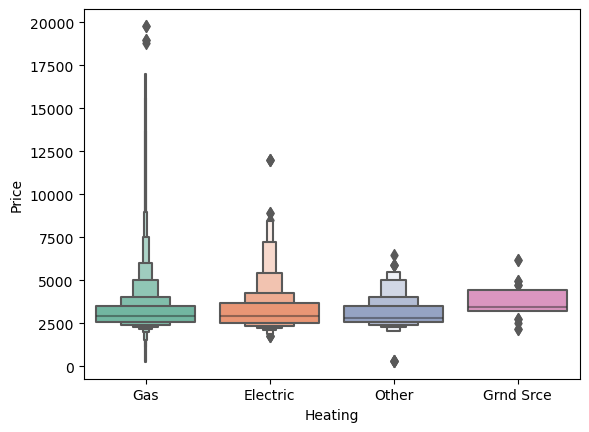

In [202]:
# Boxen plot of "total_bill" by "day" from the tips dataset with hue by "time", palette "Set2", and increased linewidth
ax = sns.boxenplot(x="Exterior", y="Price", hue="time", data=dataframe, palette="Set2", linewidth=2.5)
plt.show()

0.1409049174015765


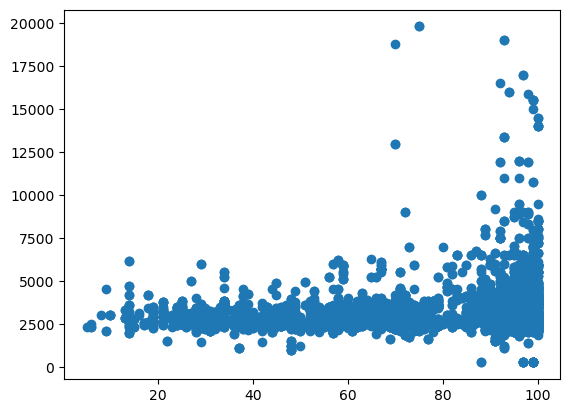

In [217]:
plt.scatter(x=dataframe['Walk Score'], y=dataframe['Price'])
correlacao = dataframe['Walk Score'].corr(dataframe['Price'])
print(correlacao)
plt.show()

0.32130807410246276


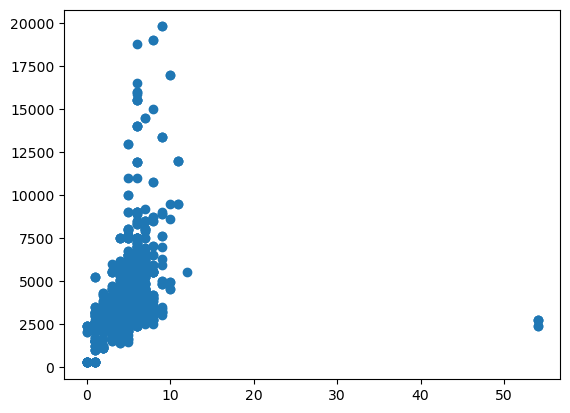

In [216]:
plt.scatter(x=dataframe['Rooms'], y=dataframe['Price'])
correlacao = dataframe['Rooms'].corr(dataframe['Price'])
print(correlacao)
plt.show()

0.5492865025774818


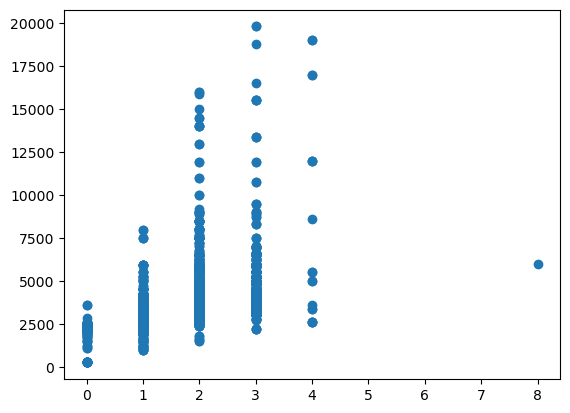

In [215]:
plt.scatter(x=dataframe['Bedrooms'], y=dataframe['Price'])
correlacao = dataframe['Bedrooms'].corr(dataframe['Price'])
print(correlacao)
plt.show()

0.5204125079615255


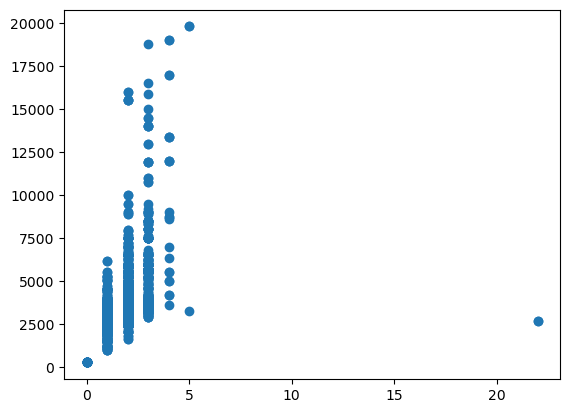

In [218]:
plt.scatter(x=dataframe['Bathrooms'], y=dataframe['Price'])
correlacao = dataframe['Bathrooms'].corr(dataframe['Price'])
print(correlacao)
plt.show()

0.7656199526727104


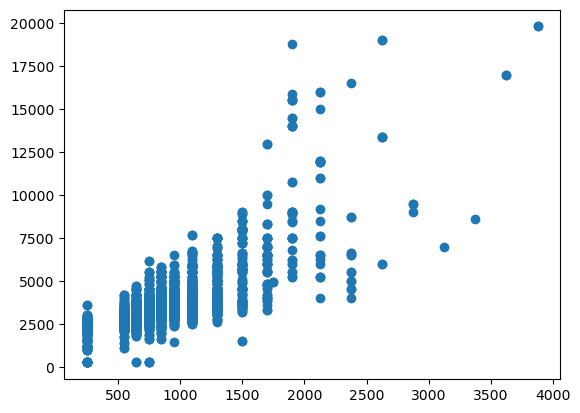

In [219]:
plt.scatter(x=dataframe['Size_mean'], y=dataframe['Price'])
correlacao = dataframe['Size_mean'].corr(dataframe['Price'])
print(correlacao)
plt.show()

0.7808406990851314


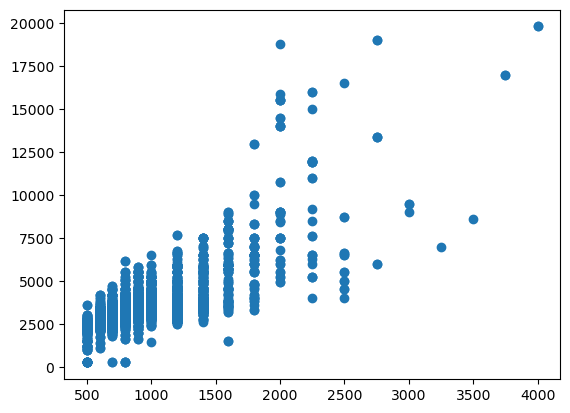

In [220]:
plt.scatter(x=dataframe['Size_max'], y=dataframe['Price'])
correlacao = dataframe['Size_max'].corr(dataframe['Price'])
print(correlacao)
plt.show()

0.729417098317098


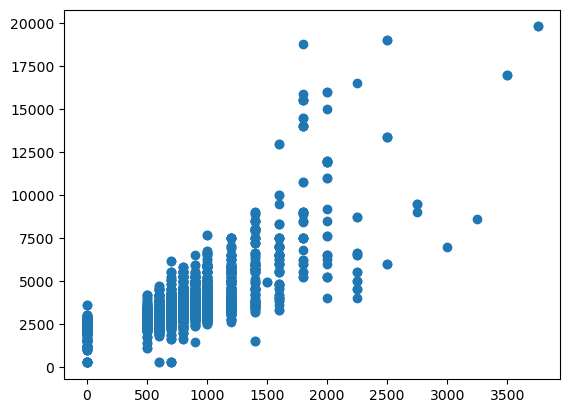

In [221]:
plt.scatter(x=dataframe['Size_min'], y=dataframe['Price'])
correlacao = dataframe['Size_min'].corr(dataframe['Price'])
print(correlacao)
plt.show()

In [14]:
dataframe.columns

Index(['Price', 'Address', 'Type', 'Style', 'Age', 'Community', 'Bedrooms',
       'Bathrooms', 'Kitchens', 'Rooms', 'Den/Family Room', 'Patio Terrace',
       'Air Conditioning', 'Fireplace', 'Handicap Equipped', 'Furnished',
       'Laundry', 'Pets', 'Stories', 'Basement', 'Elevator',
       'Energy Certificate', 'Heating', 'Green PIS', 'Exterior',
       'Private Entrance', 'Central A/C Included', 'Garage', 'Cross Street',
       'Water Included', 'Heating Included', 'Hydro Included',
       'Municipality_District', 'Building Insurance Included', 'Bedroom Plus',
       'Room Plus', 'Size', 'Walk Score', 'Added', 'Size_min', 'Size_max',
       'Size_mean'],
      dtype='object')

In [224]:
#Laundry, Furnished nao melhorou o modelo.
X = dataframe[['Bedrooms', 'Bathrooms', 'Kitchens', 'Room Plus', 'Walk Score', 'Size_mean', 'Size_max','Style', 'Municipality_District',
               'Type', 'Patio Terrace', 'Den/Family Room', 'Air Conditioning', 'Fireplace', 'Heating']]
y = dataframe['Price']

Xtr, Xval, ytr, yval = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=31)

#model = XGBRegressor(n_estimators=10, random_state=31, learning_rate=0.01)
model = RandomForestRegressor(n_estimators=620, random_state=31, max_depth=7)
model.fit(Xtr, ytr)
p = model.predict(Xval)
rmse = root_mean_squared_error(yval, p)
print(rmse)


592.0586567864384


In [ ]:
# Configure ChromeDriver options to run in headless mode
# chrome_options = Options()
# chrome_options.add_argument("--headless")  # Run the browser in the background

service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service)  # , options=chrome_options

# This block processes the data within the dictionary that represents only one property
df = pd.DataFrame(columns=['Price', 'Address', 'Status', 'Type', 'Style', 'Age', 'Area', 'Community', 'Bedrooms', 'Bathrooms',
                           'Kitchens', 'Rooms', 'Den/Family Room', 'Patio Terrace', 'Air Conditioning', 'Fireplace',
                           'Handicap Equipped', 'Furnished', 'Laundry', 'Pets', 'Stories', 'Basement', 'Elevator',
                           'Energy Certificate', 'Heating', 'Green PIS', 'Exterior', 'Private Entrance',
                           'Central A/C Included', 'Garage', 'Cross Street', 'Water Included', 'Heating Included',
                           'Hydro Included', 'Municipality_District', 'Building Insurance Included', 'Bedroom Plus',
                           'Room Plus', 'Size', 'Age_cabecalho', 'Walk Score', 'Added'])

for i, link in enumerate(df_links['links_zolo']):
    print(link)
    driver.get(link)

    try:
        header_details = driver.find_element(By.XPATH, '/html/body/section[2]/div/div/section[5]/section')
    except NoSuchElementException:
        continue

    try:
        property_details = driver.find_element(By.XPATH, '/html/body/section[2]/div/div/section[5]/div/div/section[2]')
    except NoSuchElementException:
        try:
            property_details = driver.find_element(By.XPATH, '/html/body/section[2]/div/div/section[4]/div/div/section[1]')
        except NoSuchElementException:
            continue

    try:
        price = driver.find_element(By.XPATH, '//*[@id="listing"]/div/div/section[1]/section[2]/div[1]').text
    except:
        price = 'Not available'
    try:
        address = driver.find_element(By.XPATH, '/html/body/section[2]/div/div/section[1]/section[1]/h1').text
    except:
        address = 'Not available'

    try:
        driver.find_element(By.XPATH, '/html/body/section[2]/div/div/section[5]/div/button').click()
    except:
        driver.find_element(By.XPATH, '/html/body/section[2]/div/div/section[4]/div/button').click()

    # Process the header details
    header_details = header_details.text
    header_data = header_details.split('\n')

    # Size
    Size = header_data[header_data.index('Size') + 1] if 'Size' in header_data else 'Not available'
    # Age
    Age_cabecalho = header_data[header_data.index('Age') + 1] if 'Age' in header_data else 'Not available'
    # Walk Score
    Walk_Score = header_data[header_data.index('Walk Score') + 1] if 'Walk Score' in header_data else 'Not available'
    # Added
    Added = header_data[header_data.index('Added') + 1] if 'Added' in header_data else 'Not available'

    # Process the property details
    property_details = property_details.text
    property_data = property_details.split(sep='\n')

    # Status
